In [1]:
# import data
!wget https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch16/movie_data.csv.gz
import gzip

with gzip.open('movie_data.csv.gz') as f_in, open('movie_data.csv', 'wb') as f_out:
    f_out.writelines(f_in)

--2020-03-28 01:27:31--  https://github.com/rickiepark/python-machine-learning-book-2nd-edition/raw/master/code/ch16/movie_data.csv.gz
Resolving github.com (github.com)... 13.250.177.223
Connecting to github.com (github.com)|13.250.177.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-2nd-edition/master/code/ch16/movie_data.csv.gz [following]
--2020-03-28 01:27:31--  https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-2nd-edition/master/code/ch16/movie_data.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26521894 (25M) [application/octet-stream]
Saving to: ‘movie_data.csv.gz’

movie_data.csv.gz   100%[===================>]  25.29

In [3]:
!pip install pyprind

In [4]:
import re
import pyprind
import tensorflow
import numpy as np
import pandas as pd
from string import punctuation

df = pd.read_csv('movie_data.csv', encoding='utf-8')
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [10]:
df.shape

(50000, 2)

In [5]:
# 단어 단위 분할 및 카운팅

from collections import Counter

counts = Counter()
pbar = pyprind.ProgBar(len(df['review']),
                       title='단어의 등장 횟수를 카운트합니다.')

for i,review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' '+c+' ' \
                    for c in review]).lower()

    df.loc[i,'review'] = text
    pbar.update()
    counts.update(text.split())

단어의 등장 횟수를 카운트합니다.
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:51


In [7]:
# 정수 매핑 딕셔너리

word_counts = sorted(counts, key=counts.get, reverse=True)
print(word_counts[:30])
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}


mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']),
                       title='리뷰를 정수로 매핑합니다.')
for review in df['review']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])
    pbar.update()

리뷰를 정수로 매핑합니다.


['the', '.', ',', 'and', 'a', 'of', 'to', "'", '/', 'is', '>', '<', 'br', 'it', 'in', 'i', 'this', 'that', '-', '"', 's', 'was', 'as', 'movie', 'for', 'with', 'but', 'film', ')', '(']


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


In [0]:
# 동일 길이의 시퀀스
# len < 200: left zero padding
# len >= 200: cut off

sequence_length = 200 # generally used RNN sequence length
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=int)

for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    sequences[i, -len(row):] = review_arr[-sequence_length:]

X_train = sequences[:37500, :]
y_train = df.loc[:37499, 'sentiment'].values

X_test = sequences[37500:, :]
y_test = df.loc[37500:, 'sentiment'].values

In [12]:
n_words = len(word_to_int) + 1
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(37500, 200) (37500,) (12500, 200) (12500,)


In [14]:
# define embedding layer

from tensorflow.keras import models, layers

model = models.Sequential()

model.add(layers.Embedding(n_words, 200, 
                           embeddings_regularizer='l2'))
model.add(layers.LSTM(16))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         20593400  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                13888     
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 20,607,305
Trainable params: 20,607,305
Non-trainable params: 0
_________________________________________________________________


In [15]:
# train model

model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

callback_list = [ModelCheckpoint(filepath='sentiment_rnn_checkpoint.h5',
                                 monitor='val_loss', 
                                 save_best_only=True), 
                 TensorBoard(log_dir="sentiment_rnn_logs/{}".format(
                     time.asctime()))]

history = model.fit(X_train, y_train, 
                    batch_size=64, epochs=10, 
                    validation_split=0.3, callbacks=callback_list)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


411/411 [==============================] - 65s 158ms/step - loss: 6.4885 - acc: 0.7512 - val_loss: 0.6201 - val_acc: 0.8412
Epoch 2/10
411/411 [==============================] - 65s 157ms/step - loss: 0.5861 - acc: 0.8393 - val_loss: 0.5586 - val_acc: 0.8474
Epoch 3/10
411/411 [==============================] - 65s 157ms/step - loss: 0.5448 - acc: 0.8504 - val_loss: 0.5327 - val_acc: 0.8598
Epoch 4/10
411/411 [==============================] - 64s 157ms/step - loss: 0.5127 - acc: 0.8615 - val_loss: 0.5199 - val_acc: 0.8596
Epoch 5/10
411/411 [==============================] - 64s 157ms/step - loss: 0.4988 - acc: 0.8688 - val_loss: 0.5104 - val_acc: 0.8617
Epoch 6/10
411/411 [==============================] - 64s 156ms/step - loss: 0.4846 - acc: 0.8758 - val_loss: 0.4917 - val_acc: 0.8642
Epoch 7/10
411/411 [==============================] - 64s 157ms/step - loss: 0.4677 - acc: 0.8835 - val_loss: 0.4821 - val_acc: 0.8733
Epoch 8/10
411/411 [==============================] - 64s 155ms/st

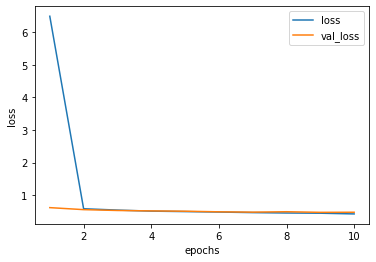

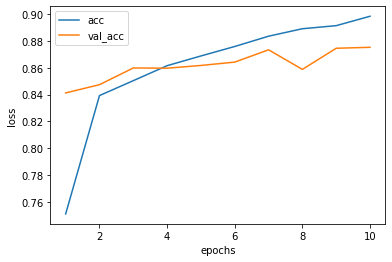

In [17]:
import matplotlib.pyplot as plt

epochs = np.arange(1, 11)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

epochs = np.arange(1, 11)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['acc', 'val_acc'])
plt.show()

In [18]:
# model evaluation

model.load_weights('sentiment_rnn_checkpoint.h5')
model.evaluate(X_test, y_test)



391/391 [==============================] - 20s 52ms/step - loss: 0.4828 - acc: 0.8667
Instructions for updating:
Please use `model.predict()` instead.


array([[0.00678457],
       [0.02304524],
       [0.00364674],
       [0.89930683],
       [0.95709056],
       [0.93537277],
       [0.02910507],
       [0.8620765 ],
       [0.00853764],
       [0.72555774]], dtype=float32)

In [21]:
print(model.predict_proba(X_test[:10]))
# pred_onehot = [1 if line > 0.5 else 0 for line in pred_res]

print(model.predict_classes(X_test[:10]))

[[0.00678457]
 [0.02304524]
 [0.00364674]
 [0.89930683]
 [0.95709056]
 [0.93537277]
 [0.02910507]
 [0.8620765 ]
 [0.00853764]
 [0.72555774]]
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]]


In [40]:
res_df = pd.DataFrame([map(int, model.predict_classes(X_test[:30])), map(int, y_test[:30])]).T
res_df.columns = ['real', 'pred']
# res_df['Correct'] = df.apply(lambda x : True if x['real'].values == x['pred'].values else False, axis=1)

res_df['correct'] = res_df['real'] == res_df['pred']
res_df

,real,pred,correct
0,0,0,True
1,0,0,True
2,0,0,True
3,1,1,True
4,1,1,True
5,1,1,True
6,0,0,True
7,1,1,True
8,0,0,True
9,1,1,True
